In [1]:
# Imports
import argparse
import os
import sys
import time
import glob
import re

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from _datetime import datetime
import scipy.stats as stats
import matplotlib.animation as animation
from matplotlib import rcParams
from PIL import Image
from sklearn.utils import resample
from scipy.stats import pearsonr
import scipy.stats as stats
import scipy

In [2]:
# Local imports
sys.path.append("/home/users/benhutch/skill-maps")
import dictionaries as dicts

sys.path.append("/home/users/benhutch/skill-maps/python")
import functions as fnc

In [3]:
# Imports of historical functions
#/home/users/benhutch/skill-maps-differences/functions.py
import os

path = "/home/users/benhutch/skill-maps-differences"
# print(os.listdir(path))

# append path and import
sys.path.append(path)
import functions_diff as hist_fnc

# # List the functions in the module
# print(dir(hist_fnc))

In [4]:
# Set up the parameters
# Test run with psl dcppA-hindcast raw data and historical data
variable = "tas"
obs_var_name = "tas"
region = "global"
region_grid = dicts.gridspec_global
forecast_range = "2-9"
season = "DJFM"
model_season = "DJFM"
start_year = "1960"
end_year = "2022"
no_bootstraps = 10

# Set up the paths
observations_path = dicts.obs
dcpp_models = dicts.common_models_noCMCC
historical_models = dicts.rsds_models_historical
base_dir = dicts.base_dir
base_dir_historical = dicts.base_dir_historical
output_dir = dicts.plots_dir
save_dir = dicts.save_dir

In [5]:
_jupyterlab_variableinspector_dict_list()

'[{"varName": "base_dir", "varType": "str", "varSize": "0", "varShape": "", "varContent": "/home/users/benhutch/skill-maps-processed-data", "isMatrix": false, "isWidget": null}, {"varName": "base_dir_historical", "varType": "str", "varSize": "0", "varShape": "", "varContent": "/home/users/benhutch/skill-maps-processed-data/his ...", "isMatrix": false, "isWidget": null}, {"varName": "dcpp_models", "varType": "list", "varSize": "0", "varShape": "10", "varContent": "[\'BCC-CSM2-MR\', \'MPI-ESM1-2-HR\', \'CanESM5\', \'HadGE ...", "isMatrix": false, "isWidget": null}, {"varName": "end_year", "varType": "str", "varSize": "0", "varShape": "", "varContent": "2022", "isMatrix": false, "isWidget": null}, {"varName": "forecast_range", "varType": "str", "varSize": "0", "varShape": "", "varContent": "2-9", "isMatrix": false, "isWidget": null}, {"varName": "historical_models", "varType": "list", "varSize": "0", "varShape": "11", "varContent": "[\'BCC-CSM2-MR\', \'MPI-ESM1-2-HR\', \'CanESM5\', \'CMCC

In [6]:
%tb
# Process the observations
obs = fnc.process_observations(variable, region, region_grid, forecast_range, season,
                                observations_path, obs_var_name, plev=None)

No traceback available to show.


Gridspec file: /home/users/benhutch/gridspec/gridspec-global.txt
Variable is not ua or va, creating new file name
File already exists
Loading ERA5 data
Dataset loaded:  [[[[244.69833 244.69833 244.69833 ... 244.69833 244.69833 244.69833]
   [243.98952 244.31924 244.6137  ... 243.28072 243.4782  243.7462 ]
   [251.60124 254.06972 254.60045 ... 251.7088  251.54306 251.9345 ]
   ...
   [247.25496 247.31139 247.20207 ... 246.92172 247.02046 247.10509]
   [246.12299 246.09302 246.05775 ... 246.36102 246.27638 246.24112]
   [245.3895  245.33836 245.29428 ... 245.57993 245.5235  245.45827]]

  [[      nan       nan       nan ...       nan       nan       nan]
   [      nan       nan       nan ...       nan       nan       nan]
   [      nan       nan       nan ...       nan       nan       nan]
   ...
   [      nan       nan       nan ...       nan       nan       nan]
   [      nan       nan       nan ...       nan       nan       nan]
   [      nan       nan       nan ...       nan       na

In [7]:
obs

<xarray.DataArray 't2m' (time: 65, lat: 72, lon: 144)>
dask.array<truediv, shape=(65, 72, 144), dtype=float64, chunksize=(8, 72, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-12-31 1960-12-31 ... 2023-12-31
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5

In [7]:
if variable in ['rsds', 'ssrd']:
    print("converting from J/m2 to W/m2")
    obs = obs / 86400

In [8]:
# Load the historical data
hist_data = hist_fnc.load_processed_historical_data(base_dir_historical, historical_models,
                                                    variable, region, forecast_range, season)

# Extract the data for the variable from the historical data
hist_data, _ = hist_fnc.extract_historical_data(hist_data, variable)

processing model:  BCC-CSM2-MR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/BCC-CSM2-MR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  MPI-ESM1-2-HR
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/MPI-ESM1-2-HR/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CanESM5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CanESM5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  CMCC-CM2-SR5
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/CMCC-CM2-SR5/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  HadGEM3-GC31-MM
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/HadGEM3-GC31-MM/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  EC-Earth3
files_path:  /home/users/benhutch/skill-maps-processed-data/historical/tas/EC-Earth3/global/years_2-9/DJFM/outputs/processed/*.nc
processing model:  M

In [9]:
# Load the DCPP data
dcpp_data = fnc.load_data(base_dir, dcpp_models, variable, region, 
                            forecast_range, model_season, level=None)

# Extract the data for the variable from the DCPP data
dcpp_data, _ = fnc.process_data(dcpp_data, variable)

Skipping file /home/users/benhutch/skill-maps-processed-data/tas/EC-Earth3/global/years_2-9/DJFM/outputs/mergetime/mergetime_EC-Earth3_tas_global_2-9_DJFM-r9i2.nc
Skipping file /home/users/benhutch/skill-maps-processed-data/tas/EC-Earth3/global/years_2-9/DJFM/outputs/mergetime/mergetime_EC-Earth3_tas_global_2-9_DJFM-r8i2.nc
Skipping file /home/users/benhutch/skill-maps-processed-data/tas/EC-Earth3/global/years_2-9/DJFM/outputs/mergetime/mergetime_EC-Earth3_tas_global_2-9_DJFM-r6i2.nc
Skipping file /home/users/benhutch/skill-maps-processed-data/tas/EC-Earth3/global/years_2-9/DJFM/outputs/mergetime/mergetime_EC-Earth3_tas_global_2-9_DJFM-r7i2.nc
Skipping file /home/users/benhutch/skill-maps-processed-data/tas/EC-Earth3/global/years_2-9/DJFM/outputs/mergetime/mergetime_EC-Earth3_tas_global_2-9_DJFM-r10i2.nc
Skipping file /home/users/benhutch/skill-maps-processed-data/tas/FGOALS-f3-L/global/years_2-9/DJFM/outputs/mergetime/mergetime_FGOALS-f3-L_tas_global_2-9_DJFM-r1i1.nc
Skipping file /ho

In [10]:
# Now we want to make sure that the time period 
# Use constrain years to make sure that the model data is the same
constrained_hist_data = fnc.constrain_years(hist_data, historical_models)

# Constrain the years for the DCPP data
constrained_dcpp_data = fnc.constrain_years(dcpp_data, dcpp_models)

# Align the forecasts and observations
fcst1, fcst2, obs_array, common_years = fnc.align_forecast1_forecast2_obs(constrained_dcpp_data, dcpp_models, 
                                                                    constrained_hist_data, historical_models, 
                                                                    obs)

There is a gap of more than 1 year in the years for model CanESM5member r1i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r13i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r11i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r16i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r18i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r20i1p2f1
There is a gap of more than 1 year in the years for model CanESM5member r1i1p2f1
adjusted indices: 54
years where gap is greater than 1: [2019 2020 2021 2023 2024]
There is a gap of more than 1 year in the years for model CanESM5member r13i1p2f1
adjusted indices: 54
years where gap is greater than 1: [2019 2020 2021 2023 2024]
There is a gap of more than 1 year in the years for model CanESM5member r11i1p2f1
adjusted indices: 54
years where gap is greater than 1: [2019 2020 2021 2023 2024]
There is a gap 

In [11]:
print(constrained_hist_data[historical_models[0]])

[<xarray.DataArray 'tas' (time: 38, lat: 72, lon: 144)>
dask.array<getitem, shape=(38, 72, 144), dtype=float32, chunksize=(38, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 80.0 82.5 85.0 87.5
    height   float64 ...
  * time     (time) object 1974-12-31 00:00:00 ... 2011-12-31 00:00:00
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K
    comment:        near-surface (usually, 2 meter) air temperature
    original_name:  TREFHT
    cell_methods:   area: time: mean (interval: 5 minutes)
    cell_measures:  area: areacella
    history:        2018-11-26T05:08:26Z altered by CMOR: Treated scalar dime..., <xarray.DataArray 'tas' (time: 38, lat: 72, lon: 144)>
dask.array<getitem, shape=(38, 72, 144), dtype=float32, chunksize=(38, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * lon 

In [12]:
# Now that we have the forecast1 array for the dcpp data
# We should be able to perform the lagging to quadruple the number of ensemble 
# members
# NOTE: Would it be worth lagging the historical members?
# Set up the lag
lag = 4

# extract the no_members
n_members = fcst1.shape[0] ; n_years = fcst1.shape[1]

# Extract the no_lats
n_lats = fcst1.shape[2] ; n_lons = fcst1.shape[3]

# Set up the no_lagged_members
n_lagged_members = n_members * lag

# Set up the lagged ensemble
lagged_ensemble = np.zeros([n_lagged_members, n_years, n_lats, n_lons])

# Loop over the ensemble members
for member in range(n_members):
    # Loop over the years
    for year in range(n_years):
        # If the year is less than the lag
        if year < lag - 1:
            # Set the lagged ensemble member equal to NaN
            lagged_ensemble[member, year, :, :] = np.nan

            # Also set the lagged ensemble member equal to NaN
            for lag_i in range(lag):
                lagged_ensemble[member + (lag_i * n_members), year, :, :] \
                = np.nan
        # Otherwise
        else:
            # Loop over the lag
            for lag_i in range(lag):
                # Set the lagged ensemble member equal to the forecast
                lagged_ensemble[member + (lag_i * n_members), year, :, :] = \
                    fcst1[member, year - lag_i, :, :]
                
# Now we have the lagged ensemble
# The first 3 years of the lagged ensemble should be NaN
# Remove these years
lagged_ensemble = lagged_ensemble[:, lag-1:, :, :]

# Do the same for the observations
lagged_obs = obs_array[lag-1:, :, :]

# Do the same for the second forecast
lagged_fcst2 = fcst2[:, lag-1:, :, :]

# Check the shape of the lagged ensemble
if lagged_ensemble[0].shape == lagged_obs.shape:
    print("lagged ensemble and observations have the same shape")
else:
    raise ValueError("lagged ensemble and observations do not have the same" +
                        "shape")

# Check the shape of the lagged ensemble
if lagged_fcst2[0].shape == lagged_obs.shape:
    print("lagged ensemble and observations have the same shape")
else:
    raise ValueError("lagged ensemble and observations do not have the same" +
                        "shape")

lagged ensemble and observations have the same shape
lagged ensemble and observations have the same shape


In [13]:
# Load up the data for the NAO matched members
base_dir_boot = "/gws/nopw/j04/canari/users/benhutch/NAO-matching"

# Set up the path to the data
path_nao_match_dir = f"{base_dir_boot}/" + \
                        f"{variable}/{region}/{season}/{forecast_range}/" + \
                            f"{start_year}-{end_year}/"

# Check if there are files in the directory
if len(os.listdir(path_nao_match_dir)) == 0:
    raise ValueError("There are no files in the directory")

# Extract the files in the directory
files = os.listdir(path_nao_match_dir)

print(files)

# Extract the file containing the lagged ensemble NAO matched mean
nao_matched_mean_file = [file for file in files if "mean_lagged" in file][0]

# Extract the file containing the lagged ensemble NAO matched members
nao_matched_members_file = [file for file in files if "members_lagged" in file][0]

# pprint the files
print("members file: ", nao_matched_members_file)
print("mean file: ", nao_matched_mean_file)

# Open the datasets using xarray
nao_matched_members = xr.open_dataset(path_nao_match_dir + 
                                        nao_matched_members_file)

nao_matched_mean = xr.open_dataset(path_nao_match_dir +
                                    nao_matched_mean_file)

['tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean.nc', 'tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean_lagged.nc', 'tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members.nc', 'tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members_lagged.nc']
members file:  tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_members_lagged.nc
mean file:  tas_global_DJFM_2-9_1960-2022_matched_var_ensemble_mean_lagged.nc


In [14]:
# # Testing nao_matched_members
# # Extract the years
# nao_matched_members_years = nao_matched_members.time.values
# print(nao_matched_members_years)

# print(nao_matched_members)

# # Extract the data for a given year
# year = 1970
# nao_matched_members_year = nao_matched_members.sel(time=year)
# print(nao_matched_members_year)

In [15]:
# Now we want to extract the consistent years from the NAO matched members
# and convert to an array
# Assert that obs must be an xarray dataset
assert isinstance(obs, xr.DataArray), "obs must be an xarray DataArray"

# First extract the years for the observations
obs_years = obs.time.dt.year.values

# Loop over the years
for year in obs_years:
    # If there are any NaN values in the observations
    obs_year = obs.sel(time=f'{year}')
    if np.isnan(obs_year.values).any():
        print(f"there are NaN values in the observations for {year}")
        if np.isnan(obs_year.values).all():
            print(f"all values are NaN for {year}")
            # Delete the year from the observations
            obs = obs.sel(time=obs.time.dt.year != year)
        else:
            print(f"not all values are NaN for {year}")
    else:
        print(f"there are no NaN values in the observations for {year}")

# Extract the constrained obs_years
obs_years = obs.time.dt.year.values

# Extract the years for the NAO matched members
nao_matched_members_years = nao_matched_members.time.values


# Check that there are no duplicate years in the NAO matched members
if len(nao_matched_members_years) != len(np.unique(nao_matched_members_years)):
    raise ValueError("there are duplicate years in the NAO matched members")

# Loop over the years for the NAO matched members
# and check that there are no NaN values
for year in nao_matched_members_years:
    # If there are any NaN values in the observations
    nao_matched_year = nao_matched_members['__xarray_dataarray_variable__'].sel(time=year)
    if np.isnan(nao_matched_year.values).any():
        print(f"there are NaN values in the NAO matched members for {year}")
        if np.isnan(nao_matched_year.values).all():
            print(f"all values are NaN for {year}")
            # Delete the year from the observations
            nao_matched_members = nao_matched_members.sel(time=nao_matched_members.time.values != year)
        else:
            print(f"not all values are NaN for {year}")
    else:
        print(f"there are no NaN values in the NAO matched members for {year}")

# Extract the years for the constrained historical data
constrained_hist_data_years = constrained_hist_data[historical_models[0]][0]. \
time.dt.year.values

# If the years for the NAO matched members are not the same as the
# constrained historical data
if np.array_equal(nao_matched_members_years, 
                    constrained_hist_data_years) == False:
    print("years for NAO matched members and constrained historical data" +
            "are not the same")
    
    # Find the common years
    common_years = np.intersect1d(nao_matched_members_years, 
                                    constrained_hist_data_years)
    
    # Extract the common years from the NAO matched members
    common_years_mask = np.in1d(nao_matched_members.time.values, common_years)

    # Extract the common years from the NAO matched members
    nao_matched_members = nao_matched_members.isel(time=common_years_mask)
    
    constrained_hist_data_nmatch = {}

    # Extract the common years from the constrained historical data
    for model in historical_models:
        model_data = constrained_hist_data[model]
        for member in model_data:
            # Extract the years for the member
            member_years = member.time.dt.year.values

            # If the years for the member are not the same as the common years
            if np.array_equal(member_years, common_years) == False:
                print(f"years for {model} member {member} are not the same" +
                        "as the common years")
                # Extract the common years for the member
                member = member.sel(time=member.time.dt.year.isin(common_years))
            
            # Append to the list
            if model not in constrained_hist_data_nmatch:
                constrained_hist_data_nmatch[model] = []

            constrained_hist_data_nmatch[model].append(member)

    # Check the new years
    nao_matched_years = nao_matched_members.time.values

    # Check the new years for the constrained historical data
    constrained_hist_data_nmatch_years = constrained_hist_data_nmatch[historical_models[0]][0]. \
    time.dt.year.values

    # Assert that the arrays are the same
    assert np.array_equal(nao_matched_years, 
                            constrained_hist_data_nmatch_years) == True, \
                                "the years are not the same"

    # Set the variables to the new values
    nao_matched_members_years = nao_matched_years
    
# If the forecast1 and forecast2 are now the same
common_f_years = nao_matched_members_years

# If the obs_years and common_f_years are not the same
if np.array_equal(obs_years, common_f_years) == False:
    print("obs_years and common_f_years are not the same")
    # Find the common years
    common_years = np.intersect1d(obs_years, common_f_years)
    
    # Extract the common years from the observations
    obs = obs.sel(time=obs.time.dt.year.isin(common_years))
    
    # Use a boolean mask to extract the common years from the NAO matched members
    common_years_mask = np.in1d(nao_matched_members.time.values, common_years)

    # Extract the common years from the NAO matched members
    nao_matched_members = nao_matched_members.isel(time=common_years_mask)
    
    constrained_hist_data_nmatch_obs = {}

    # Extract the common years from the constrained historical data
    for model in historical_models:
        model_data = constrained_hist_data[model]
        for member in model_data:
            # Extract the years for the member
            member_years = member.time.dt.year.values

            # If the years for the member are not the same as the common years
            if np.array_equal(member_years, common_years) == False:
                print(f"years for {model} member {member} are not the same" +
                        "as the common years")
                # Extract the common years for the member
                member = member.sel(time=member.time.dt.year.isin(common_years))
            
            # Append to the list
            if model not in constrained_hist_data_nmatch_obs:
                constrained_hist_data_nmatch_obs[model] = []

            constrained_hist_data_nmatch_obs[model].append(member)

    # Check the new years
    obs_years = obs.time.dt.year.values

    # Check the new years for the constrained historical data
    constrained_hist_data_nmatch_years = constrained_hist_data_nmatch_obs[historical_models[0]][0]. \
    time.dt.year.values

    # Assert that the arrays are the same
    assert np.array_equal(obs_years, 
                            constrained_hist_data_nmatch_years) == True, \
                                "the years are not the same"

    # Extract the nao_matched_years again
    nao_matched_years = nao_matched_members.time.values

    # Assert that the arrays are the same
    assert np.array_equal(obs_years, 
                            nao_matched_years) == True, \
                                "the years are not the same"
    
# Extract the arrays from the datasets
nao_matched_members = nao_matched_members['__xarray_dataarray_variable__'].values

# Extract the obs
obs = obs.values

# Extract the no ensemble members for f2 (historical data)
n_members_hist = np.sum([len(constrained_hist_data_nmatch_obs[model]) for model in constrained_hist_data_nmatch_obs])

# Create an empty array for the historical data
hist_data_array = np.zeros([n_members_hist, len(obs_years), n_lats, n_lons])

# Initialise the counter
member_index = 0

# Loop over the models
for model in historical_models:
    # Extract the model data
    model_data = constrained_hist_data_nmatch_obs[model]

    # Loop over the members
    for member in model_data:
        # Extract the member data
        member_data = member.values

        # Add to the array
        hist_data_array[member_index, :, :, :] = member_data

        # Add to the counter
        member_index += 1



# If the time axis, with len(obs_years), is not the second axis
# of the nao_matched_members
if nao_matched_members.shape[1] != len(obs_years):
    print("time axis of nao_matched_members is not the second axis")

    # Swap the first and second axes
    nao_matched_members = np.swapaxes(nao_matched_members, 0, 1)

# Print the shape of the array
print("shape of the historical data array: ", hist_data_array.shape)
print("shape of the NAO matched members: ", nao_matched_members.shape)
print("shape of the observations: ", obs.shape)

# Extract the first ensemble member
nao_matched_members_ens1 = nao_matched_members[0]
hist_data_array_ens1 = hist_data_array[0]

# Assert that the array shapes are the same
assert nao_matched_members_ens1.shape == hist_data_array_ens1.shape, \
    "array shapes are not the same"

# Assert that the array shapes are the same
assert nao_matched_members_ens1.shape == obs.shape, \
    "array shapes are not the same"


there are NaN values in the observations for 1959
all values are NaN for 1959
there are NaN values in the observations for 1960
all values are NaN for 1960
there are NaN values in the observations for 1961
all values are NaN for 1961
there are NaN values in the observations for 1962
all values are NaN for 1962
there are no NaN values in the observations for 1963
there are no NaN values in the observations for 1964
there are no NaN values in the observations for 1965
there are no NaN values in the observations for 1966
there are no NaN values in the observations for 1967
there are no NaN values in the observations for 1968
there are no NaN values in the observations for 1969
there are no NaN values in the observations for 1970
there are no NaN values in the observations for 1971
there are no NaN values in the observations for 1972
there are no NaN values in the observations for 1973
there are no NaN values in the observations for 1974
there are no NaN values in the observations for 1975

In [16]:
# Now we can test the bootstrapping function
forecast_stats_raw = fnc.forecast_stats(obs_array, fcst1, fcst2, no_boot=10)

bootstrap index 0


shape of obs_boot (38, 72, 144)
value of obs_boot [[[-0.32924223 -0.32924223 -0.32924223 ... -0.32924223 -0.32924223
   -0.32924223]
  [-0.36438847 -0.36949444 -0.37200975 ... -0.36276722 -0.36501646
   -0.36397696]
  [-0.53058386 -0.55416393 -0.59644413 ... -0.36558676 -0.36083698
   -0.36065626]
  ...
  [-1.00803804 -1.02301216 -1.02853155 ... -1.02635288 -1.04169703
   -1.02891064]
  [-1.20584297 -1.20113564 -1.19793177 ... -1.17407608 -1.19993687
   -1.19767332]
  [-1.46059036 -1.4607234  -1.46110392 ... -1.46979046 -1.47078371
   -1.46767426]]

 [[-0.3590517  -0.3590517  -0.3590517  ... -0.3590517  -0.3590517
   -0.3590517 ]
  [-0.36576557 -0.37671232 -0.38683224 ... -0.33846807 -0.34683371
   -0.35549164]
  [-0.47515345 -0.47019148 -0.53225279 ... -0.39225483 -0.39527416
   -0.36798477]
  ...
  [-1.11834764 -1.11392689 -1.10247517 ... -1.18068838 -1.18567228
   -1.15701723]
  [-1.27576447 -1.26830196 -1.26074553 ... -1.26449585 -1.28098869
   -1.27519941]
  [-1.58748579 -1.584036

In [17]:
# process the forecast stats for the lagged ensemble
forecast_stats_lagged = fnc.forecast_stats(lagged_obs, lagged_ensemble, 
                                            lagged_fcst2, no_boot=10)

bootstrap index 0


shape of obs_boot (35, 72, 144)
value of obs_boot [[[-0.27237988 -0.27237988 -0.27237988 ... -0.27237988 -0.27237988
   -0.27237988]
  [-0.08492136 -0.08859491 -0.09122086 ... -0.06798172 -0.07469606
   -0.07927418]
  [-0.03457403 -0.07137775 -0.07839489 ... -0.01586676 -0.04577541
   -0.03881693]
  ...
  [-0.63131857 -0.60640192 -0.58271694 ... -0.68759871 -0.68800831
   -0.66772938]
  [-0.68294382 -0.67603302 -0.66616201 ... -0.65272141 -0.67373276
   -0.68000889]
  [-0.90110588 -0.89567375 -0.8892765  ... -0.89598036 -0.90093994
   -0.90196323]]

 [[-0.11909246 -0.11909246 -0.11909246 ... -0.11909246 -0.11909246
   -0.11909246]
  [ 0.05392981  0.0468955   0.04002714 ...  0.07549906  0.06933498
    0.0620575 ]
  [ 0.00405073 -0.011374   -0.02775764 ...  0.03118801  0.02425671
    0.04598284]
  ...
  [-1.27290249 -1.23834276 -1.20666933 ... -1.30295467 -1.31537676
   -1.30479527]
  [-1.24419165 -1.23480129 -1.22465515 ... -1.21198606 -1.23310614
   -1.24103642]
  [-1.38058519 -1.37658

In [18]:
# Process the forecast stats for the NAO matched members
forecast_stats_nao_matched = fnc.forecast_stats(obs_array, nao_matched_members, 
                                                hist_data_array, no_boot=10)

bootstrap index 0
shape of obs_boot (38, 72, 144)
value of obs_boot [[[-0.32924223 -0.32924223 -0.32924223 ... -0.32924223 -0.32924223
   -0.32924223]
  [-0.36438847 -0.36949444 -0.37200975 ... -0.36276722 -0.36501646
   -0.36397696]
  [-0.53058386 -0.55416393 -0.59644413 ... -0.36558676 -0.36083698
   -0.36065626]
  ...
  [-1.00803804 -1.02301216 -1.02853155 ... -1.02635288 -1.04169703
   -1.02891064]
  [-1.20584297 -1.20113564 -1.19793177 ... -1.17407608 -1.19993687
   -1.19767332]
  [-1.46059036 -1.4607234  -1.46110392 ... -1.46979046 -1.47078371
   -1.46767426]]

 [[-0.3590517  -0.3590517  -0.3590517  ... -0.3590517  -0.3590517
   -0.3590517 ]
  [-0.36576557 -0.37671232 -0.38683224 ... -0.33846807 -0.34683371
   -0.35549164]
  [-0.47515345 -0.47019148 -0.53225279 ... -0.39225483 -0.39527416
   -0.36798477]
  ...
  [-1.11834764 -1.11392689 -1.10247517 ... -1.18068838 -1.18567228
   -1.15701723]
  [-1.27576447 -1.26830196 -1.26074553 ... -1.26449585 -1.28098869
   -1.27519941]
  [-1.

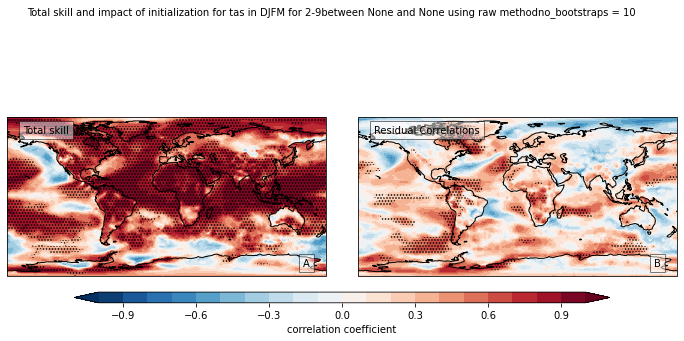

In [22]:
from plotting_functions import plot_raw_init_impact

# Set up the variables
corr1_raw = forecast_stats_raw['corr1']
corr1_p_raw = forecast_stats_raw['corr1_p']
r_partial_raw = forecast_stats_raw['partialr']
r_partial_p_raw = forecast_stats_raw['partialr_p']
no_bootstraps = no_bootstraps
nens1_raw = forecast_stats_raw['nens1']
nens2_raw = forecast_stats_raw['nens2']
len_years = len(obs_years)
plots_dir = "/gws/nopw/j04/canari/users/benhutch/plots"
method = "raw"

# Call the function
plot_raw_init_impact(corr1_raw, corr1_p_raw, r_partial_raw, r_partial_p_raw,
                        variable, season, forecast_range, method,
                        no_bootstraps, nens1_raw, nens2_raw, None, None,
                        plots_dir)


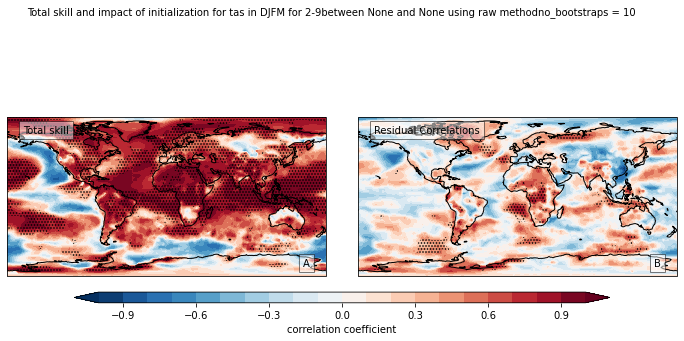

In [23]:
# Do the same for the lagged ensemble
corr1_lagged = forecast_stats_lagged['corr1']
corr1_p_lagged = forecast_stats_lagged['corr1_p']
r_partial_lagged = forecast_stats_lagged['partialr']
r_partial_p_lagged = forecast_stats_lagged['partialr_p']
no_bootstraps = no_bootstraps
nens1_lagged = forecast_stats_lagged['nens1']
nens2_lagged = forecast_stats_lagged['nens2']
len_years = len(obs_years)
plots_dir = "/gws/nopw/j04/canari/users/benhutch/plots"

# Call the function
plot_raw_init_impact(corr1_lagged, corr1_p_lagged, r_partial_lagged, 
                        r_partial_p_lagged, variable, season, forecast_range, 
                        method, no_bootstraps, nens1_lagged, nens2_lagged, 
                        None, None, plots_dir)

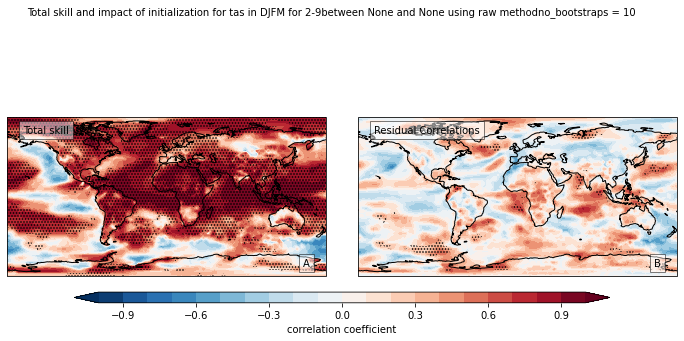

In [24]:
# Do the same for the NAO matched members
corr1_nao_matched = forecast_stats_nao_matched['corr1']
corr1_p_nao_matched = forecast_stats_nao_matched['corr1_p']
r_partial_nao_matched = forecast_stats_nao_matched['partialr']
r_partial_p_nao_matched = forecast_stats_nao_matched['partialr_p']
no_bootstraps = no_bootstraps
nens1_nao_matched = forecast_stats_nao_matched['nens1']
nens2_nao_matched = forecast_stats_nao_matched['nens2']
len_years = len(obs_years)
plots_dir = "/gws/nopw/j04/canari/users/benhutch/plots"

# Call the function
plot_raw_init_impact(corr1_nao_matched, corr1_p_nao_matched, 
                        r_partial_nao_matched, r_partial_p_nao_matched, 
                        variable, season, forecast_range, method, 
                        no_bootstraps, nens1_nao_matched, nens2_nao_matched, 
                        None, None, plots_dir)